# Data Cleaning Notebook.

This notebook contains: 
- The code to read-in and clean the data for our modeling purposes.
- Basic information on the dataset.
- Basic EDA.

## <a href="https://thejk.medium.com/i-will-predict-the-2023-nba-mvp-using-machine-learning-8e7ed688b0d3">Data Source</a>:

### <a href="https://www.kaggle.com/datasets/danchyy/nba-mvp-votings-through-history?resource=download">Alternative Data Source (cleaner but not as up to date)</a>:

### <a href="https://www.basketball-reference.com/about/glossary.html">Variable Definitions</a>:

In [17]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/wyattscott/Documents/DS5110/Project')

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

import warnings
warnings.filterwarnings('ignore')


from scipy.stats import randint
from pandas_profiling import ProfileReport

In [2]:
df = pd.read_csv('mvp_data.csv')

In [ ]:
df.columns

In [ ]:
df.info()

In [ ]:
df.describe()

---

# Cleaning:

One thing to consider here is that the rules change over time, for example, the minimum number of games a player must be on the court for recently changed to 65. In the code below, it's set at 65.

In [3]:
# Fill missing values
df['Rank'].fillna(0, inplace=True)
df['mvp_share'].fillna(0.0, inplace=True)
df['Trp Dbl'].fillna(0, inplace=True)

# Normalize Triple Double
df['Trp Dbl'] = df['Trp Dbl'] / df['G']

# Convert 'G' and 'Season' to integer type
df['G'] = df['G'].astype(int)
df['Season'] = df['Season'].astype(int)

# Filter out data based on conditions
df = df[(df['G'] > 65) & (df['Season'] <= 2022)]

# Ranking Conference
df['Rk_Conference'] = df.groupby(['Season', 'conference'])['W'].rank("dense", ascending=False) + df['Rk_Season']
df['Rk_Conference'] = df.groupby(['Season', 'conference'])['Rk_Conference'].rank("dense", ascending=True)

# Save cleaned data to CSV
df.drop(columns=['conference', 'W'], inplace=True)

# Sort out seasons we'll use for testing/predictions
df.sort_values(by=['Season'], ascending=False, inplace=True)
df_last = df[df['Season'] > (2022 - 5)] 
last_names = df_last['name'].values
last_seasons = df_last['Season'].values
del df_last['name']
del df_last['Season']
del df_last['Rank']
del df_last['mvp_share']

# Filter for seasons older than 5 years
df = df[df['Season'] <= (2022 - 5)].copy()
df.drop(columns=['name'], inplace=True)

In [4]:
df.head()

,height,weight,Season,Age,Pos,G,GS,MP,FG,FGA,...,OBPM,DBPM,BPM,VORP,Rank,mvp_share,Trp Dbl,Rk_Season,Overall,Rk_Conference
7625,190.0,215.0,2017,28.0,SG,75,15.0,31.0,5.5,13.5,...,1.3,-1.4,-0.1,1.1,0.0,0.0,0.000000,3,0.670732,3.0
7307,203.0,220.0,2017,26.0,SF,75,75.0,35.9,8.3,18.0,...,3.0,0.1,3.1,3.4,0.0,0.0,0.000000,13,0.512195,6.0
16168,190.0,195.0,2017,22.0,PG,82,58.0,29.4,5.2,11.1,...,0.8,0.0,0.8,1.7,0.0,0.0,0.060976,26,0.353659,13.0
7645,211.0,240.0,2017,32.0,C,82,82.0,31.2,4.8,8.2,...,-0.3,-0.5,-0.8,0.8,0.0,0.0,0.000000,9,0.597561,4.0
6773,201.0,205.0,2017,24.0,SG,68,66.0,32.9,6.0,13.7,...,-0.2,-1.1,-1.3,0.4,0.0,0.0,0.000000,26,0.353659,13.0


In [5]:
last_names = pd.DataFrame(last_names, columns=['name'])
last_seasons = pd.DataFrame(last_seasons, columns=['Season'])
last_names.to_csv('last_names.csv', index=False)
last_seasons.to_csv('last_seasons.csv', index=False)

In [6]:
df.isnull().sum()

height              0
weight              0
Season              0
Age                 0
Pos                 0
G                   0
GS               3070
MP                 87
FG                  0
FGA                 0
FG%                 0
3P               2755
3PA              2755
3P%              3284
2P               1822
2PA              1822
2P%              1822
eFG%             1822
FT                  0
FTA                 0
FT%                 0
ORB              1800
DRB              1800
TRB                44
AST                 0
STL              1800
BLK              1800
TOV              2397
PF                  0
PTS                 0
PER                87
TS%                 0
3PAr             2755
FTr                 0
ORB%             1800
DRB%             1800
TRB%             1409
AST%              872
STL%             1800
BLK%             1800
TOV%             2397
USG%             2397
OWS                 0
DWS                 0
WS                  0
WS/48     

### There are a lot of missing values, so we must further clean and investigate. 

Three-point shots weren't introduced until 1979-80, and there are a lot of missing values before then, so we drop any season < 1980.

In [7]:
df = df[df['Season'] >= 1980]
df.drop(['Season'], axis="columns", inplace=True)

In [8]:
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")

In [9]:
df.columns

Index(['height', 'weight', 'Age', 'Pos', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER',
       'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
       'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'Trp Dbl', 'Rk_Season', 'Overall', 'Rk_Conference'],
      dtype='object')

In [10]:
df.isnull().sum()

height             0
weight             0
Age                0
Pos                0
G                  0
GS               335
MP                 0
FG                 0
FGA                0
FG%                0
3P                 0
3PA                0
3P%              529
2P                 0
2PA                0
2P%                0
eFG%               0
FT                 0
FTA                0
FT%                0
ORB                0
DRB                0
TRB                0
AST                0
STL                0
BLK                0
TOV                0
PF                 0
PTS                0
PER                0
TS%                0
3PAr               0
FTr                0
ORB%               0
DRB%               0
TRB%               0
AST%               0
STL%               0
BLK%               0
TOV%               0
USG%               0
OWS                0
DWS                0
WS                 0
WS/48              0
OBPM               0
DBPM               0
BPM          

## There are still some null values: 
* 529 3P% (3-point percent)
* 335 for GS (games started)

We create a separate dataframe and fill these missing values with 0 for now, but we revisit this later.

In [11]:
df_corr = df.copy()
df_corr.fillna(0, inplace=True)
# Drop position column for corrplot below
df_corr.drop(['Pos'], axis="columns", inplace=True)

# EDA 

### `Pandas_Profiling`

If you want this to run faster, set `minimal=True`

In [ ]:
profile = ProfileReport(df, 
                        title='Pandas Profiling Report',
                        html={'style':{'full_width':True}},
                       minimal=True)
profile.to_notebook_iframe()

### sns `Corrplot`

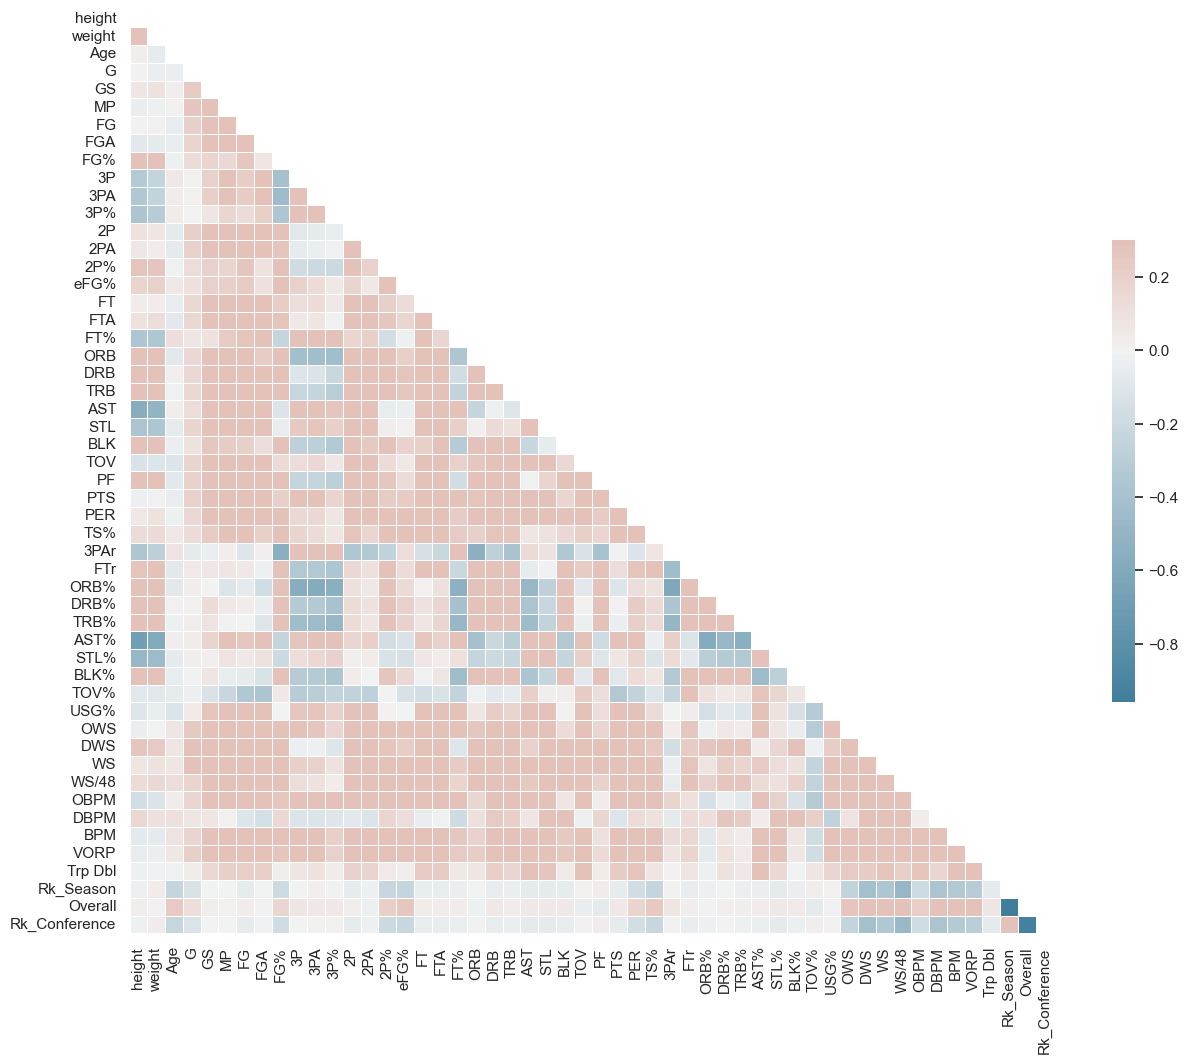

In [12]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()